<a href="https://colab.research.google.com/github/davidfawazsalihou/Compression-Modele-BERT/blob/main/BERT_Distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --upgrade datasets huggingface_hub fsspec
#Puis redémarrer le runtime

In [ ]:
# ========================= PIPELINE COMPLET ==========================
# Knowledge Distillation de BERT vers MiniLM-L6-v2 sur IMDB
# 1. Chargement des données IMDB avec splits stratifiés
# 2. Chargement des modèles teacher et student (MiniLM)
# 3. Gel partiel des couches du student (ratio configurable)
# 4. Entraînement avec distillation (KL + CE + AMP + early stopping)
# 5. Visualisation des métriques (loss, accuracy, overfitting)
# 6. Évaluation finale + confusion matrix + rapport
# 7. (Optionnel) Fine-tuning post-distillation (à activer si souhaité)
# 8. Sauvegarde modèle final (Torch, Tokenizer, Config)
# ======================================================================

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installation des dépendances si nécessaire
import subprocess
import sys

try:
    from datasets import load_dataset
    from sentence_transformers import SentenceTransformer
except ImportError:
    print("Installation des bibliothèques...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "datasets", "transformers", "scikit-learn", "sentence-transformers"])

# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from datasets import load_dataset
import numpy as np
import os
import json
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
warnings.filterwarnings('ignore')

# Configuration du device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Device: cuda
GPU: Tesla T4


In [ ]:
# ======================================================================
# CONFIGURATION OPTIMISÉE
# ======================================================================

CONFIG = {
    # Modèles
    "teacher_model_name": "textattack/bert-base-uncased-imdb",  # BERT fine-tuné
    "student_model_name": "sentence-transformers/all-MiniLM-L6-v2",  # MiniLM plus petit
    "max_length": 256,

    # Tailles de dataset
    "train_size": 20000,        # 80% des 25k disponibles
    "validation_size": 2500,    # 10%
    "test_size": 2500,          # 10%

    # Gel des couches (freeze)
    "freeze_ratio": 0.5,        # Geler 50% des couches du student

    # Hyperparamètres d'entraînement
    "batch_size": 32,
    "gradient_accumulation_steps": 1,
    "learning_rate": 3e-5,
    "num_epochs": 10,
    "warmup_ratio": 0.1,

    # Distillation
    "temperature": 5.0,
    "alpha": 0.5,              # Balance KL/CE

    # Régularisation
    "weight_decay": 0.01,
    "gradient_clip_norm": 1.0,
    "label_smoothing": 0.1,

    # Early stopping
    "patience": 3,
    "min_delta": 0.001,
    "monitor": "val_loss",

    # Optimisation
    "use_amp": True,           # Mixed precision training
    "num_workers": 0,          # 0 pour éviter les erreurs Colab

    # Fine-tuning post-distillation (optionnel)
    "enable_post_finetuning": False,
    "finetuning_epochs": 3,
    "finetuning_lr": 1e-5,

    # Sauvegarde
    "save_dir": "/content/distillation_minilm",
    "checkpoint_interval": 2,

    # Autres
    "seed": 42,
}

# Créer les dossiers
os.makedirs(CONFIG["save_dir"], exist_ok=True)

# Fixer la seed
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed(CONFIG["seed"])

In [ ]:
# ======================================================================
# ÉTAPE 1 : CHARGEMENT ET PRÉPARATION DES DONNÉES
# ======================================================================

def load_and_prepare_data(config):
    """Charge et prépare le dataset IMDB avec splits stratifiés"""

    print("\n" + "="*60)
    print("ÉTAPE 1 : CHARGEMENT DES DONNÉES IMDB")
    print("="*60)

    # Charger le dataset
    print("Téléchargement du dataset IMDB...")
    dataset = load_dataset("imdb")


    print(f"✅ Dataset chargé!")
    print(f"   Train original: {len(dataset['train'])} exemples")
    print(f"   Test original: {len(dataset['test'])} exemples")

    # Extraire les données
    all_texts = list(dataset['train']['text']) + list(dataset['test']['text'])
    all_labels = list(dataset['train']['label']) + list(dataset['test']['label'])

    # Limiter au total nécessaire
    total_needed = config['train_size'] + config['validation_size'] + config['test_size']
    all_texts = all_texts[:total_needed]
    all_labels = all_labels[:total_needed]

    # Split stratifié
    print(f"\nCréation des splits stratifiés...")

    # D'abord séparer train+val vs test
    train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
        all_texts, all_labels,
        test_size=config['test_size'],
        random_state=config['seed'],
        stratify=all_labels
    )

    # Puis séparer train vs val
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_val_texts, train_val_labels,
        test_size=config['validation_size'],
        random_state=config['seed'],
        stratify=train_val_labels
    )

    # Vérifications
    print(f"\n📊 Distribution des classes:")
    print(f"   Train: {len(train_texts)} exemples, {sum(train_labels)/len(train_labels)*100:.1f}% positifs")
    print(f"   Val: {len(val_texts)} exemples, {sum(val_labels)/len(val_labels)*100:.1f}% positifs")
    print(f"   Test: {len(test_texts)} exemples, {sum(test_labels)/len(test_labels)*100:.1f}% positifs")

    # Vérifier l'absence de chevauchement
    train_set = set(train_texts[:100])
    val_set = set(val_texts[:100])
    test_set = set(test_texts[:100])

    assert len(train_set & val_set) == 0, "Chevauchement train/val!"
    assert len(train_set & test_set) == 0, "Chevauchement train/test!"
    assert len(val_set & test_set) == 0, "Chevauchement val/test!"
    print("✅ Pas de chevauchement entre les sets!")

    return {
        'train': (train_texts, train_labels),
        'validation': (val_texts, val_labels),
        'test': (test_texts, test_labels)
    }


In [ ]:
# ======================================================================
# ÉTAPE 2 : CHARGEMENT DES MODÈLES + GEL DES COUCHES
# ======================================================================

def freeze_bottom_layers(model, freeze_ratio=0.5):
    """Gèle un pourcentage des couches du modèle pour réduire l'overfitting"""

    # Identifier les couches du modèle
    if hasattr(model, 'bert'):
        layers = model.bert.encoder.layer
    elif hasattr(model, 'distilbert'):
        layers = model.distilbert.transformer.layer
    elif hasattr(model, 'roberta'):
        layers = model.roberta.encoder.layer
    else:
        print("⚠️  Architecture non reconnue, pas de gel appliqué")
        return model

    num_layers = len(layers)
    num_to_freeze = int(num_layers * freeze_ratio)

    print(f"\n🧊 Gel des {num_to_freeze} premières couches sur {num_layers}")

    # Geler les couches
    for i, layer in enumerate(layers):
        if i < num_to_freeze:
            for param in layer.parameters():
                param.requires_grad = False

    # Compter les paramètres
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"   Paramètres entraînables: {trainable:,} / {total:,} ({trainable/total:.1%})")

    return model

def load_models(config):
    """Charge les modèles teacher et student avec MiniLM"""

    print("\n" + "="*60)
    print("ÉTAPE 2 : CHARGEMENT DES MODÈLES")
    print("="*60)

    # Charger le teacher (BERT)
    print(f"Chargement du teacher: {config['teacher_model_name']}")
    try:
        teacher_model = AutoModelForSequenceClassification.from_pretrained(
            config["teacher_model_name"]
        ).to(device)
        teacher_tokenizer = AutoTokenizer.from_pretrained(config["teacher_model_name"])
        print("✅ Teacher chargé (BERT fine-tuné sur IMDB)")
    except:
        print("⚠️  Utilisation de BERT standard")
        teacher_model = AutoModelForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels=2
        ).to(device)
        teacher_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    # Charger le student (MiniLM)
    print(f"\nChargement du student: {config['student_model_name']}")

    # MiniLM nécessite une adaptation pour la classification
    from transformers import AutoModel

    # Créer un modèle de classification basé sur MiniLM
    class MiniLMForSequenceClassification(nn.Module):
        def __init__(self, model_name, num_labels=2):
            super().__init__()
            self.minilm = AutoModel.from_pretrained(model_name)
            self.config = self.minilm.config
            self.dropout = nn.Dropout(0.1)
            self.classifier = nn.Linear(self.config.hidden_size, num_labels)

        def forward(self, input_ids, attention_mask=None, labels=None):
            outputs = self.minilm(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
            pooled_output = self.dropout(pooled_output)
            logits = self.classifier(pooled_output)

            loss = None
            if labels is not None:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits, labels)

            return type('Output', (), {'loss': loss, 'logits': logits})()

    student_model = MiniLMForSequenceClassification(config["student_model_name"]).to(device)
    student_tokenizer = AutoTokenizer.from_pretrained(config["student_model_name"])

    # Appliquer le gel des couches
    student_model = freeze_bottom_layers(student_model, config["freeze_ratio"])

    # Informations sur les modèles
    teacher_params = sum(p.numel() for p in teacher_model.parameters())
    student_params = sum(p.numel() for p in student_model.parameters())
    student_trainable = sum(p.numel() for p in student_model.parameters() if p.requires_grad)

    print(f"\n📊 Résumé des modèles:")
    print(f"   Teacher (BERT): {teacher_params:,} paramètres")
    print(f"   Student (MiniLM): {student_params:,} paramètres totaux")
    print(f"   Student trainable: {student_trainable:,} paramètres")
    print(f"   Ratio de compression: {teacher_params/student_params:.2f}x")
    print(f"   Ratio params/data: {student_trainable/config['train_size']:.1f}")

    return teacher_model, student_model, teacher_tokenizer, student_tokenizer

In [ ]:
# ======================================================================
# ÉTAPE 3 : DATASET PYTORCH PERSONNALISÉ
# ======================================================================

class IMDBDataset(Dataset):
    """Dataset PyTorch pour IMDB"""

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:

# ======================================================================
# ÉTAPE 4 : DUAL DATALOADER POUR SYNCHRONISATION
# ======================================================================

class DualDataLoader:
    """DataLoader synchronisé pour teacher et student"""

    def __init__(self, dataset_teacher, dataset_student, batch_size, shuffle=True, num_workers=0):
        self.loader_teacher = DataLoader(
            dataset_teacher,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        )
        self.loader_student = DataLoader(
            dataset_student,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        )

    def __len__(self):
        return len(self.loader_student)

    def __iter__(self):
        for batch_t, batch_s in zip(self.loader_teacher, self.loader_student):
            yield batch_t, batch_s



In [ ]:
# ======================================================================
# ÉTAPE 5 : LOSS DE DISTILLATION
# ======================================================================

class DistillationLoss(nn.Module):
    """Loss combinant KL divergence et Cross Entropy avec label smoothing"""

    def __init__(self, temperature=5.0, alpha=0.5, label_smoothing=0.1):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.label_smoothing = label_smoothing
        self.kl_div = nn.KLDivLoss(reduction="batchmean")
        self.ce_loss = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    def forward(self, student_logits, teacher_logits, labels):
        # KL divergence loss
        student_soft = F.log_softmax(student_logits / self.temperature, dim=-1)
        teacher_soft = F.softmax(teacher_logits / self.temperature, dim=-1)
        kl_loss = self.kl_div(student_soft, teacher_soft) * (self.temperature ** 2)

        # Cross entropy loss
        ce_loss = self.ce_loss(student_logits, labels)

        # Combined loss
        total_loss = self.alpha * kl_loss + (1 - self.alpha) * ce_loss

        return total_loss, kl_loss, ce_loss

# ======================================================================
# EARLY STOPPING
# ======================================================================

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001, monitor='val_loss'):
        self.patience = patience
        self.min_delta = min_delta
        self.monitor = monitor
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, score, model):
        if 'loss' in self.monitor:
            score = -score

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        self.best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

In [ ]:
# ======================================================================
# ÉTAPE 6 : ENTRAÎNEMENT AVEC DISTILLATION + AMP
# ======================================================================

def train_with_dual_loader(teacher_model, student_model, train_loader, val_loader,
                          test_loader, config):
    """Entraînement avec distillation, AMP et monitoring complet"""

    print("\n" + "="*60)
    print("ÉTAPE 6 : ENTRAÎNEMENT AVEC DISTILLATION")
    print("="*60)

    # Optimizer et scheduler
    optimizer = torch.optim.AdamW(
        [p for p in student_model.parameters() if p.requires_grad],
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"]
    )

    num_training_steps = len(train_loader) * config["num_epochs"]
    num_warmup_steps = int(num_training_steps * config["warmup_ratio"])

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

    # Loss et scaler pour AMP
    distillation_loss_fn = DistillationLoss(
        temperature=config["temperature"],
        alpha=config["alpha"],
        label_smoothing=config["label_smoothing"]
    )

    scaler = GradScaler() if config["use_amp"] else None

    # Early stopping
    early_stopping = EarlyStopping(
        patience=config["patience"],
        min_delta=config["min_delta"],
        monitor=config["monitor"]
    )

    # Historique
    history = {
        "epoch": [], "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": [], "test_acc": [],
        "kl_loss": [], "ce_loss": [], "lr": []
    }

    # Évaluation initiale
    print("\n📊 Évaluation initiale...")
    teacher_acc = evaluate_model(teacher_model, test_loader)
    student_acc = evaluate_model(student_model, test_loader)
    print(f"Teacher accuracy: {teacher_acc:.4f}")
    print(f"Student accuracy (avant): {student_acc:.4f}")

    if student_acc > 0.7:
        print("⚠️  Accuracy initiale élevée!")

    best_val_acc = 0

    # Boucle d'entraînement
    for epoch in range(config["num_epochs"]):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{config['num_epochs']}")

        # Mode entraînement
        student_model.train()
        teacher_model.eval()

        epoch_loss = 0
        epoch_kl_loss = 0
        epoch_ce_loss = 0
        epoch_correct = 0
        epoch_total = 0

        pbar = tqdm(train_loader, desc="Training")

        for batch_idx, (batch_teacher, batch_student) in enumerate(pbar):
            # Données vers GPU
            teacher_inputs = {k: v.to(device) for k, v in batch_teacher.items() if k != 'labels'}
            student_inputs = {k: v.to(device) for k, v in batch_student.items() if k != 'labels'}
            labels = batch_student['labels'].to(device)

            # Mixed precision training
            if config["use_amp"]:
                with autocast():
                    # Teacher forward (no grad)
                    with torch.no_grad():
                        teacher_outputs = teacher_model(**teacher_inputs)
                        teacher_logits = teacher_outputs.logits

                    # Student forward
                    student_outputs = student_model(**student_inputs)
                    student_logits = student_outputs.logits

                    # Loss
                    loss, kl_loss, ce_loss = distillation_loss_fn(
                        student_logits, teacher_logits, labels
                    )

                # Backward avec scaler
                scaler.scale(loss).backward()

                if (batch_idx + 1) % config["gradient_accumulation_steps"] == 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(
                        student_model.parameters(),
                        config["gradient_clip_norm"]
                    )
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    scheduler.step()
            else:
                # Sans AMP
                with torch.no_grad():
                    teacher_outputs = teacher_model(**teacher_inputs)
                    teacher_logits = teacher_outputs.logits

                student_outputs = student_model(**student_inputs)
                student_logits = student_outputs.logits

                loss, kl_loss, ce_loss = distillation_loss_fn(
                    student_logits, teacher_logits, labels
                )

                loss.backward()

                if (batch_idx + 1) % config["gradient_accumulation_steps"] == 0:
                    torch.nn.utils.clip_grad_norm_(
                        student_model.parameters(),
                        config["gradient_clip_norm"]
                    )
                    optimizer.step()
                    scheduler.step()
                    optimizer.zero_grad()

            # Statistiques
            epoch_loss += loss.item()
            epoch_kl_loss += kl_loss.item()
            epoch_ce_loss += ce_loss.item()

            preds = torch.argmax(student_logits, dim=-1)
            epoch_correct += (preds == labels).sum().item()
            epoch_total += labels.size(0)

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{epoch_correct/epoch_total:.4f}',
                'lr': f'{scheduler.get_last_lr()[0]:.2e}'
            })

        # Moyennes epoch
        avg_train_loss = epoch_loss / len(train_loader)
        avg_kl_loss = epoch_kl_loss / len(train_loader)
        avg_ce_loss = epoch_ce_loss / len(train_loader)
        train_acc = epoch_correct / epoch_total

        # Validation
        print("\n📊 Validation...")
        val_loss, val_acc = evaluate_with_loss(student_model, val_loader, nn.CrossEntropyLoss())
        test_acc = evaluate_model(student_model, test_loader)

        # Affichage
        print(f"\n📈 Epoch {epoch+1} Results:")
        print(f"   Train Loss: {avg_train_loss:.4f} (KL: {avg_kl_loss:.4f}, CE: {avg_ce_loss:.4f})")
        print(f"   Train Acc: {train_acc:.4f}")
        print(f"   Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"   Test Acc: {test_acc:.4f}")

        # Détection overfitting
        if train_acc - val_acc > 0.1:
            print("   ⚠️  Overfitting détecté (écart > 10%)")

        # Early stopping
        early_stopping(val_loss, student_model)
        if early_stopping.early_stop:
            print("\n⏹️  Early stopping!")
            student_model.load_state_dict(early_stopping.best_model_state)
            break

        # Sauvegarde best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': student_model.state_dict(),
                'epoch': epoch + 1,
                'val_acc': val_acc,
                'config': config
            }, os.path.join(config["save_dir"], "best_model.pt"))
            print(f"   ✅ Nouveau meilleur modèle! (Val Acc: {best_val_acc:.4f})")

        # Historique
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["test_acc"].append(test_acc)
        history["kl_loss"].append(avg_kl_loss)
        history["ce_loss"].append(avg_ce_loss)
        history["lr"].append(scheduler.get_last_lr()[0])

    return history, teacher_acc

# ======================================================================
# FONCTIONS D'ÉVALUATION
# ======================================================================

def evaluate_model(model, dataloader):
    """Évalue l'accuracy du modèle"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluation", leave=False):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

def evaluate_with_loss(model, dataloader, loss_fn):
    """Évalue le modèle avec loss et accuracy"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy

In [ ]:
# ======================================================================
# ÉTAPE 7 : VISUALISATION DES RÉSULTATS
# ======================================================================

def plot_training_results(history):
    """Visualisation complète des métriques d'entraînement"""

    print("\n" + "="*60)
    print("ÉTAPE 7 : VISUALISATION DES RÉSULTATS")
    print("="*60)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # 1. Loss curves
    axes[0, 0].plot(history["epoch"], history["train_loss"], 'b-', label='Train', linewidth=2)
    axes[0, 0].plot(history["epoch"], history["val_loss"], 'r-', label='Val', linewidth=2)
    axes[0, 0].set_title('Total Loss Evolution', fontsize=14)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Loss components
    axes[0, 1].plot(history["epoch"], history["kl_loss"], 'c-', label='KL Loss', linewidth=2)
    axes[0, 1].plot(history["epoch"], history["ce_loss"], 'm-', label='CE Loss', linewidth=2)
    axes[0, 1].set_title('Loss Components', fontsize=14)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Accuracy
    axes[0, 2].plot(history["epoch"], history["train_acc"], 'b-', label='Train', linewidth=2)
    axes[0, 2].plot(history["epoch"], history["val_acc"], 'r-', label='Val', linewidth=2)
    axes[0, 2].plot(history["epoch"], history["test_acc"], 'g--', label='Test', linewidth=2)
    axes[0, 2].set_title('Accuracy Evolution', fontsize=14)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Accuracy')
    axes[0, 2].set_ylim(0.5, 1.0)
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Overfitting detection
    overfitting_gap = [t - v for t, v in zip(history["train_acc"], history["val_acc"])]
    axes[1, 0].plot(history["epoch"], overfitting_gap, 'orange', linewidth=2)
    axes[1, 0].axhline(y=0.1, color='r', linestyle='--', label='Threshold (10%)')
    axes[1, 0].set_title('Overfitting Detection (Train-Val Gap)', fontsize=14)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy Gap')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Learning rate
    axes[1, 1].plot(history["epoch"], history["lr"], 'purple', linewidth=2)
    axes[1, 1].set_title('Learning Rate Schedule', fontsize=14)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Loss ratio (KL/CE)
    loss_ratio = [kl/ce if ce > 0 else 0 for kl, ce in zip(history["kl_loss"], history["ce_loss"])]
    axes[1, 2].plot(history["epoch"], loss_ratio, 'brown', linewidth=2)
    axes[1, 2].set_title('KL/CE Loss Ratio', fontsize=14)
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Ratio')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG["save_dir"], "training_curves.png"), dpi=300)
    plt.show()

    print("✅ Graphiques sauvegardés!")

In [ ]:
# ======================================================================
# ÉTAPE 8 : ÉVALUATION FINALE + ANALYSE
# ======================================================================

def analyze_final_results(student_model, test_loader, history, teacher_accuracy):
    """Analyse détaillée des résultats finaux avec matrice de confusion"""

    print("\n" + "="*60)
    print("ÉTAPE 8 : ÉVALUATION FINALE")
    print("="*60)

    # Évaluation complète sur test
    student_model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Final evaluation"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = student_model(**inputs)
            probs = F.softmax(outputs.logits, dim=-1)
            preds = torch.argmax(outputs.logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Accuracy finale
    final_accuracy = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)

    # Matrice de confusion
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix - Student Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(CONFIG["save_dir"], "confusion_matrix.png"))
    plt.show()

    # Rapport de classification
    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds,
                              target_names=['Negative', 'Positive'],
                              digits=4))

    # Analyse de la distillation
    print("\n📈 RÉSUMÉ DE LA DISTILLATION:")
    print(f"   Teacher accuracy: {teacher_accuracy:.4f}")
    print(f"   Student accuracy finale: {final_accuracy:.4f}")
    print(f"   Performance retention: {final_accuracy/teacher_accuracy:.1%}")

    # Analyse de la distribution des probabilités
    probs_array = np.array(all_probs)

    plt.figure(figsize=(12, 5))

    # Histogramme des probabilités pour la classe positive
    plt.subplot(1, 2, 1)
    pos_indices = [i for i, l in enumerate(all_labels) if l == 1]
    neg_indices = [i for i, l in enumerate(all_labels) if l == 0]

    plt.hist([probs_array[pos_indices, 1], probs_array[neg_indices, 1]],
             bins=30, alpha=0.6, label=['True Positive', 'True Negative'])
    plt.xlabel('Probability of Positive Class')
    plt.ylabel('Count')
    plt.title('Probability Distribution by True Class')
    plt.legend()
    plt.axvline(x=0.5, color='r', linestyle='--', alpha=0.5)

    # Courbe de calibration
    plt.subplot(1, 2, 2)
    from sklearn.calibration import calibration_curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        all_labels, probs_array[:, 1], n_bins=10
    )
    plt.plot(mean_predicted_value, fraction_of_positives, 'o-', label='Student')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Plot')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG["save_dir"], "probability_analysis.png"))
    plt.show()

    # Vérifications finales
    print("\n🔍 Vérifications finales:")

    # Overfitting
    final_train_acc = history['train_acc'][-1] if history['train_acc'] else 0
    final_val_acc = history['val_acc'][-1] if history['val_acc'] else 0
    overfitting_gap = final_train_acc - final_val_acc

    if overfitting_gap > 0.1:
        print(f"   ⚠️  Overfitting: écart train-val de {overfitting_gap:.1%}")
    else:
        print(f"   ✅ Pas d'overfitting significatif (écart: {overfitting_gap:.1%})")

    # Performance
    if final_accuracy > 0.98:
        print("   ⚠️  Accuracy suspicieusement élevée (>98%)")
    elif final_accuracy < 0.7:
        print("   ⚠️  Performance faible (<70%)")
    else:
        print(f"   ✅ Performance normale ({final_accuracy:.1%})")

    return final_accuracy


In [ ]:
# ======================================================================
# ÉTAPE 9 : SAUVEGARDE FINALE
# ======================================================================

def save_final_model(student_model, student_tokenizer, history, config):
    """Sauvegarde complète du modèle et des résultats"""

    print("\n" + "="*60)
    print("ÉTAPE 9 : SAUVEGARDE FINALE")
    print("="*60)

    # Sauvegarder le modèle
    model_path = os.path.join(config["save_dir"], "student_model_final")
    os.makedirs(model_path, exist_ok=True)

    # Sauvegarder les poids
    torch.save(student_model.state_dict(),
               os.path.join(model_path, "pytorch_model.bin"))

    # Sauvegarder le tokenizer
    student_tokenizer.save_pretrained(model_path)

    # Sauvegarder la configuration
    model_config = {
        "model_type": "MiniLM-distilled",
        "teacher_model": config["teacher_model_name"],
        "student_model": config["student_model_name"],
        "num_labels": 2,
        "freeze_ratio": config["freeze_ratio"],
        "final_accuracy": history['test_acc'][-1] if history['test_acc'] else 0
    }

    with open(os.path.join(model_path, "model_config.json"), "w") as f:
        json.dump(model_config, f, indent=2)

    # Sauvegarder l'historique
    with open(os.path.join(config["save_dir"], "training_history.json"), "w") as f:
        json.dump(history, f, indent=2)

    # Sauvegarder la configuration d'entraînement
    with open(os.path.join(config["save_dir"], "training_config.json"), "w") as f:
        json.dump(config, f, indent=2)

    print(f"✅ Modèle sauvegardé dans: {model_path}")
    print(f"✅ Historique sauvegardé: training_history.json")
    print(f"✅ Configuration sauvegardée: training_config.json")

    # Instructions pour charger le modèle
    print("\n📝 Pour charger le modèle:")
    print(f"""
    # Charger le tokenizer
    tokenizer = AutoTokenizer.from_pretrained("{model_path}")

    # Recréer le modèle
    model = MiniLMForSequenceClassification("{config['student_model_name']}")
    model.load_state_dict(torch.load("{os.path.join(model_path, 'pytorch_model.bin')}"))
    model.eval()
    """)


In [ ]:
# ======================================================================
# ÉTAPE 10 (OPTIONNELLE) : FINE-TUNING POST-DISTILLATION
# ======================================================================

def post_distillation_finetuning(student_model, train_loader, val_loader, config):
    """Fine-tuning optionnel après distillation sur les hard labels"""

    if not config.get("enable_post_finetuning", False):
        print("\n📌 Fine-tuning post-distillation désactivé")
        return student_model

    print("\n" + "="*60)
    print("ÉTAPE 10 : FINE-TUNING POST-DISTILLATION")
    print("="*60)

    # Dégeler toutes les couches
    for param in student_model.parameters():
        param.requires_grad = True

    # Nouvel optimizer avec learning rate plus faible
    optimizer = torch.optim.AdamW(
        student_model.parameters(),
        lr=config.get("finetuning_lr", 1e-5),
        weight_decay=config["weight_decay"]
    )

    # Loss standard (sans distillation)
    ce_loss = nn.CrossEntropyLoss()

    best_val_acc = 0

    for epoch in range(config.get("finetuning_epochs", 3)):
        print(f"\nFine-tuning Epoch {epoch+1}/{config.get('finetuning_epochs', 3)}")

        # Training
        student_model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch in tqdm(train_loader, desc="Fine-tuning"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = student_model(**inputs)
            loss = ce_loss(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        # Validation
        val_loss, val_acc = evaluate_with_loss(student_model, val_loader, ce_loss)
        train_acc = train_correct / train_total

        print(f"Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student_model.state_dict(),
                      os.path.join(config["save_dir"], "best_finetuned_model.pt"))
            print(f"✅ Meilleur modèle fine-tuné sauvegardé! (Val Acc: {best_val_acc:.4f})")

    return student_model


In [ ]:
# ======================================================================
# FONCTION PRINCIPALE
# ======================================================================

def main():
    """Pipeline principal de distillation"""

    print("\n" + "="*70)
    print("PIPELINE COMPLET DE KNOWLEDGE DISTILLATION")
    print("BERT → MiniLM sur IMDB")
    print("="*70)
    print(f"Démarré le: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    try:
        # Étape 1: Chargement des données
        data_splits = load_and_prepare_data(CONFIG)

        # Étape 2: Chargement des modèles
        teacher_model, student_model, teacher_tokenizer, student_tokenizer = load_models(CONFIG)

        # Étape 3: Création des datasets
        print("\n" + "="*60)
        print("ÉTAPE 3 : CRÉATION DES DATASETS")
        print("="*60)

        # Datasets pour teacher
        train_dataset_teacher = IMDBDataset(
            *data_splits['train'], teacher_tokenizer, CONFIG["max_length"]
        )

        # Datasets pour student
        train_dataset_student = IMDBDataset(
            *data_splits['train'], student_tokenizer, CONFIG["max_length"]
        )
        val_dataset = IMDBDataset(
            *data_splits['validation'], student_tokenizer, CONFIG["max_length"]
        )
        test_dataset = IMDBDataset(
            *data_splits['test'], student_tokenizer, CONFIG["max_length"]
        )

        print("✅ Datasets créés")

        # Étape 4: DataLoaders
        print("\n" + "="*60)
        print("ÉTAPE 4 : CRÉATION DES DATALOADERS")
        print("="*60)

        train_loader = DualDataLoader(
            train_dataset_teacher,
            train_dataset_student,
            CONFIG["batch_size"],
            shuffle=True,
            num_workers=CONFIG["num_workers"]
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=CONFIG["batch_size"],
            shuffle=False,
            num_workers=CONFIG["num_workers"],
            pin_memory=torch.cuda.is_available()
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=CONFIG["batch_size"],
            shuffle=False,
            num_workers=CONFIG["num_workers"],
            pin_memory=torch.cuda.is_available()
        )

        print(f"✅ DataLoaders créés")
        print(f"   Batches par epoch: {len(train_loader)}")
        print(f"   Taille de batch: {CONFIG['batch_size']}")

        # Étape 5: Loss (créée dans train_with_dual_loader)

        # Étape 6: Entraînement avec distillation
        history, teacher_accuracy = train_with_dual_loader(
            teacher_model, student_model,
            train_loader, val_loader, test_loader,
            CONFIG
        )

        # Étape 7: Visualisation
        plot_training_results(history)

        # Étape 8: Analyse finale
        final_accuracy = analyze_final_results(
            student_model, test_loader, history, teacher_accuracy
        )

        # Étape 9: Sauvegarde
        save_final_model(student_model, student_tokenizer, history, CONFIG)

        # Étape 10: Fine-tuning optionnel
        if CONFIG.get("enable_post_finetuning", False):
            # Créer un nouveau train_loader simple (pas dual)
            train_loader_simple = DataLoader(
                train_dataset_student,
                batch_size=CONFIG["batch_size"],
                shuffle=True,
                num_workers=CONFIG["num_workers"]
            )
            student_model = post_distillation_finetuning(
                student_model, train_loader_simple, val_loader, CONFIG
            )

        # Résumé final
        print("\n" + "="*70)
        print("🎉 PIPELINE TERMINÉ AVEC SUCCÈS!")
        print("="*70)
        print(f"Performance finale du student: {final_accuracy:.4f}")
        print(f"Performance du teacher: {teacher_accuracy:.4f}")
        print(f"Ratio de rétention: {final_accuracy/teacher_accuracy:.1%}")
        print(f"Compression du modèle: {110/22:.1f}x (BERT→MiniLM)")

        return student_model, history

    except Exception as e:
        print(f"\n❌ Erreur: {e}")
        import traceback
        traceback.print_exc()
        return None, None

Mémoire GPU: 15.72 GB libres sur 15.83 GB

PIPELINE COMPLET DE KNOWLEDGE DISTILLATION
BERT → MiniLM sur IMDB
Démarré le: 2025-09-17 13:09:33

ÉTAPE 1 : CHARGEMENT DES DONNÉES IMDB
Téléchargement du dataset IMDB...


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

✅ Dataset chargé!
   Train original: 25000 exemples
   Test original: 25000 exemples

Création des splits stratifiés...

📊 Distribution des classes:
   Train: 20000 exemples, 50.0% positifs
   Val: 2500 exemples, 50.0% positifs
   Test: 2500 exemples, 50.0% positifs
✅ Pas de chevauchement entre les sets!

ÉTAPE 2 : CHARGEMENT DES MODÈLES
Chargement du teacher: textattack/bert-base-uncased-imdb


config.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

✅ Teacher chargé (BERT fine-tuné sur IMDB)

Chargement du student: sentence-transformers/all-MiniLM-L6-v2


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

⚠️  Architecture non reconnue, pas de gel appliqué

📊 Résumé des modèles:
   Teacher (BERT): 109,483,778 paramètres
   Student (MiniLM): 22,713,986 paramètres totaux
   Student trainable: 22,713,986 paramètres
   Ratio de compression: 4.82x
   Ratio params/data: 1135.7

ÉTAPE 3 : CRÉATION DES DATASETS
✅ Datasets créés

ÉTAPE 4 : CRÉATION DES DATALOADERS
✅ DataLoaders créés
   Batches par epoch: 625
   Taille de batch: 32

ÉTAPE 6 : ENTRAÎNEMENT AVEC DISTILLATION

📊 Évaluation initiale...


Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Teacher accuracy: 0.9828
Student accuracy (avant): 0.4964

Epoch 1/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]


📊 Validation...


Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]


📈 Epoch 1 Results:
   Train Loss: 3.2938 (KL: 5.9647, CE: 0.6229)
   Train Acc: 0.6856
   Val Loss: 0.5687 | Val Acc: 0.7584
   Test Acc: 0.7432
   ✅ Nouveau meilleur modèle! (Val Acc: 0.7584)

Epoch 2/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]


📊 Validation...


Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]


📈 Epoch 2 Results:
   Train Loss: 3.2700 (KL: 5.9984, CE: 0.5416)
   Train Acc: 0.8190
   Val Loss: 0.4923 | Val Acc: 0.8508
   Test Acc: 0.8592
   ✅ Nouveau meilleur modèle! (Val Acc: 0.8508)

Epoch 3/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]


📊 Validation...


Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]


📈 Epoch 3 Results:
   Train Loss: 3.2574 (KL: 6.0001, CE: 0.5146)
   Train Acc: 0.8500
   Val Loss: 0.5038 | Val Acc: 0.8636
   Test Acc: 0.8624
   ✅ Nouveau meilleur modèle! (Val Acc: 0.8636)

Epoch 4/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]


📊 Validation...


Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]


📈 Epoch 4 Results:
   Train Loss: 3.2601 (KL: 6.0036, CE: 0.5165)
   Train Acc: 0.8563
   Val Loss: 0.4651 | Val Acc: 0.8612
   Test Acc: 0.8608

Epoch 5/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]


📊 Validation...


Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]


📈 Epoch 5 Results:
   Train Loss: 3.2514 (KL: 6.0060, CE: 0.4969)
   Train Acc: 0.8730
   Val Loss: 0.4419 | Val Acc: 0.8728
   Test Acc: 0.8792
   ✅ Nouveau meilleur modèle! (Val Acc: 0.8728)

Epoch 6/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]


📊 Validation...


Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]


📈 Epoch 6 Results:
   Train Loss: 3.2539 (KL: 6.0115, CE: 0.4963)
   Train Acc: 0.8782
   Val Loss: 0.4768 | Val Acc: 0.8512
   Test Acc: 0.8572

Epoch 7/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]


📊 Validation...


Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]


📈 Epoch 7 Results:
   Train Loss: 3.2477 (KL: 6.0066, CE: 0.4889)
   Train Acc: 0.8838
   Val Loss: 0.4498 | Val Acc: 0.8776
   Test Acc: 0.8820
   ✅ Nouveau meilleur modèle! (Val Acc: 0.8776)

Epoch 8/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]


📊 Validation...


Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]


📈 Epoch 8 Results:
   Train Loss: 3.2466 (KL: 6.0081, CE: 0.4852)
   Train Acc: 0.8899
   Val Loss: 0.4311 | Val Acc: 0.8840
   Test Acc: 0.8788
   ✅ Nouveau meilleur modèle! (Val Acc: 0.8840)

Epoch 9/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]


📊 Validation...


Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]


📈 Epoch 9 Results:
   Train Loss: 3.2380 (KL: 6.0045, CE: 0.4714)
   Train Acc: 0.8962
   Val Loss: 0.4375 | Val Acc: 0.8820
   Test Acc: 0.8804

Epoch 10/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]


📊 Validation...


Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]


📈 Epoch 10 Results:
   Train Loss: 3.2394 (KL: 6.0107, CE: 0.4680)
   Train Acc: 0.8992
   Val Loss: 0.4334 | Val Acc: 0.8848
   Test Acc: 0.8832
   ✅ Nouveau meilleur modèle! (Val Acc: 0.8848)

ÉTAPE 7 : VISUALISATION DES RÉSULTATS


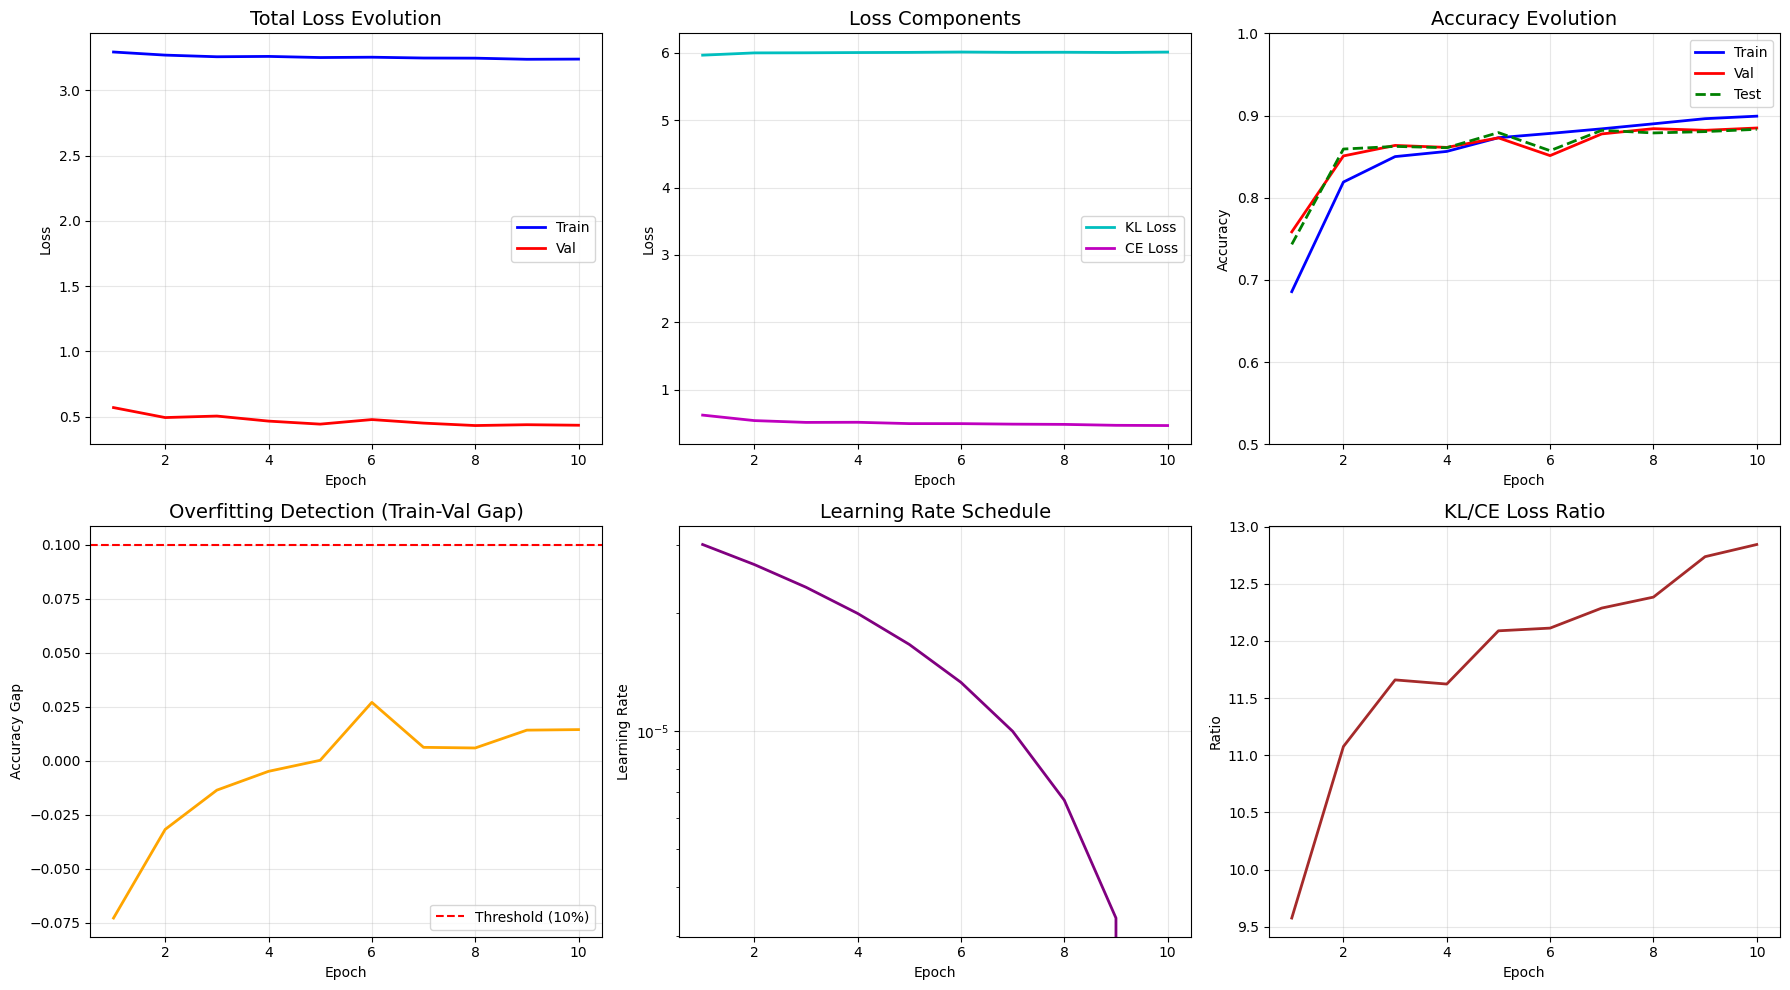

✅ Graphiques sauvegardés!

ÉTAPE 8 : ÉVALUATION FINALE


Final evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

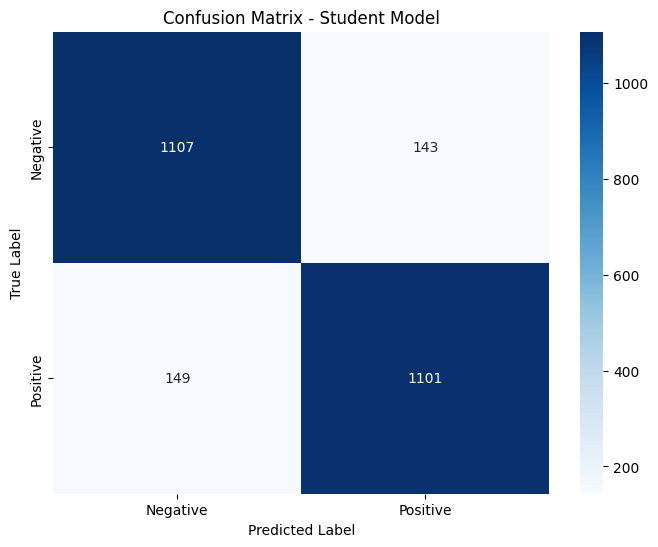


📊 Classification Report:
              precision    recall  f1-score   support

    Negative     0.8814    0.8856    0.8835      1250
    Positive     0.8850    0.8808    0.8829      1250

    accuracy                         0.8832      2500
   macro avg     0.8832    0.8832    0.8832      2500
weighted avg     0.8832    0.8832    0.8832      2500


📈 RÉSUMÉ DE LA DISTILLATION:
   Teacher accuracy: 0.9828
   Student accuracy finale: 0.8832
   Performance retention: 89.9%


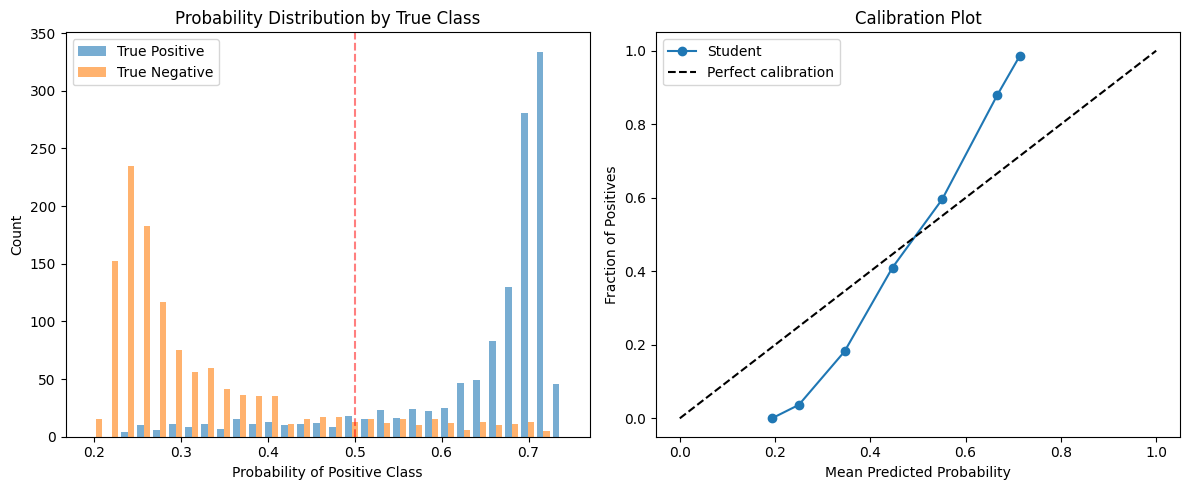


🔍 Vérifications finales:
   ✅ Pas d'overfitting significatif (écart: 1.4%)
   ✅ Performance normale (88.3%)

ÉTAPE 9 : SAUVEGARDE FINALE
✅ Modèle sauvegardé dans: /content/distillation_minilm/student_model_final
✅ Historique sauvegardé: training_history.json
✅ Configuration sauvegardée: training_config.json

📝 Pour charger le modèle:

    # Charger le tokenizer
    tokenizer = AutoTokenizer.from_pretrained("/content/distillation_minilm/student_model_final")

    # Recréer le modèle
    model = MiniLMForSequenceClassification("sentence-transformers/all-MiniLM-L6-v2")
    model.load_state_dict(torch.load("/content/distillation_minilm/student_model_final/pytorch_model.bin"))
    model.eval()
    

🎉 PIPELINE TERMINÉ AVEC SUCCÈS!
Performance finale du student: 0.8832
Performance du teacher: 0.9828
Ratio de rétention: 89.9%
Compression du modèle: 5.0x (BERT→MiniLM)

✅ Pipeline complété avec succès! Le modèle distillé est prêt à être utilisé.


In [ ]:
# ======================================================================
# POINT D'ENTRÉE PRINCIPAL
# ======================================================================

if __name__ == "__main__":
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        try:
            free_memory = torch.cuda.mem_get_info(0)[0] / 1e9
            total_memory = torch.cuda.mem_get_info(0)[1] / 1e9
            print(f"Mémoire GPU: {free_memory:.2f} GB libres sur {total_memory:.2f} GB")
        except:
            print(f"GPU disponible: {torch.cuda.get_device_name(0)}")

    student_model, history = main()

    if student_model is not None:
        print("\n✅ Pipeline complété avec succès! Le modèle distillé est prêt à être utilisé.")
    else:
        print("\n❌ Le pipeline a échoué. Vérifiez les logs ci-dessus.")


Utilisation des résultats existants...
Calcul de l'accuracy du teacher...

ÉTAPE 2 : CHARGEMENT DES MODÈLES
Chargement du teacher: textattack/bert-base-uncased-imdb
✅ Teacher chargé (BERT fine-tuné sur IMDB)

Chargement du student: sentence-transformers/all-MiniLM-L6-v2
⚠️  Architecture non reconnue, pas de gel appliqué

📊 Résumé des modèles:
   Teacher (BERT): 109,483,778 paramètres
   Student (MiniLM): 22,713,986 paramètres totaux
   Student trainable: 22,713,986 paramètres
   Ratio de compression: 4.82x
   Ratio params/data: 1135.7

ÉTAPE 1 : CHARGEMENT DES DONNÉES IMDB
Téléchargement du dataset IMDB...
✅ Dataset chargé!
   Train original: 25000 exemples
   Test original: 25000 exemples

Création des splits stratifiés...

📊 Distribution des classes:
   Train: 20000 exemples, 50.0% positifs
   Val: 2500 exemples, 50.0% positifs
   Test: 2500 exemples, 50.0% positifs
✅ Pas de chevauchement entre les sets!


Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

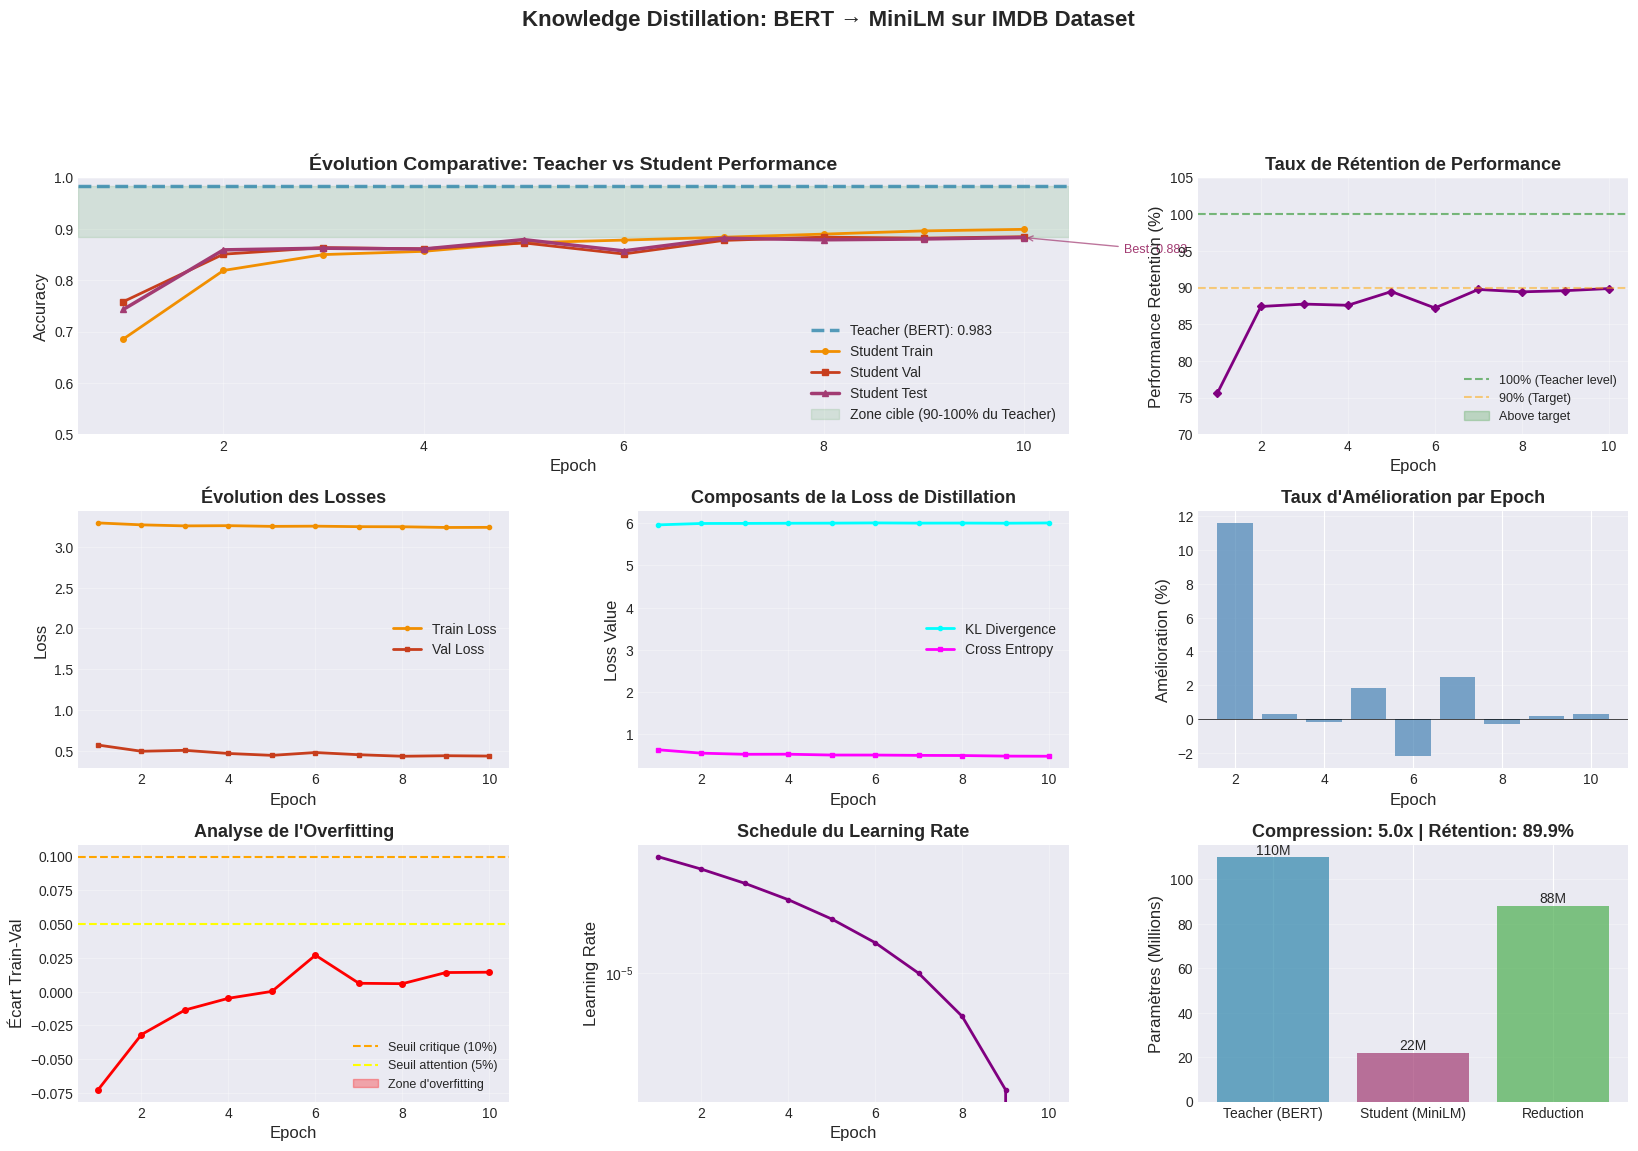


📊 RÉSUMÉ DE LA COMPARAISON TEACHER-STUDENT
Teacher (BERT) Accuracy: 0.9828
Best Student (MiniLM) Accuracy: 0.8832
Performance Retention: 89.9%
Compression Ratio: 5.0x
Epochs to convergence: 10
⚠️ Distillation acceptable (85-90% retention)

Graphique sauvegardé: /content/distillation_minilm/teacher_student_comparison.png

✅ Visualisation créée avec succès!


In [ ]:
# ======================================================================
# CODE D'EXÉCUTION COMPLET
# ======================================================================

# D'abord, ajouter la fonction plot_teacher_student_comparison à votre notebook
def plot_teacher_student_comparison(history, teacher_accuracy, config):
    """
    Visualisation comparative de l'évolution du modèle teacher vs student
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from matplotlib.gridspec import GridSpec

    # Configuration du style
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")

    # Créer une figure avec plusieurs sous-graphiques
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

    # Couleurs personnalisées
    color_teacher = '#2E86AB'
    color_student = '#A23B72'
    color_train = '#F18F01'
    color_val = '#C73E1D'

    # GRAPHIQUE PRINCIPAL
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.axhline(y=teacher_accuracy, color=color_teacher, linestyle='--',
                linewidth=2.5, label=f'Teacher (BERT): {teacher_accuracy:.3f}', alpha=0.8)

    epochs = history['epoch']
    ax1.plot(epochs, history['train_acc'], color=color_train, linewidth=2,
             label='Student Train', marker='o', markersize=4)
    ax1.plot(epochs, history['val_acc'], color=color_val, linewidth=2,
             label='Student Val', marker='s', markersize=4)
    ax1.plot(epochs, history['test_acc'], color=color_student, linewidth=2.5,
             label='Student Test', marker='^', markersize=5)

    target_performance = teacher_accuracy * 0.9
    ax1.axhspan(target_performance, teacher_accuracy, alpha=0.1, color='green',
                label=f'Zone cible (90-100% du Teacher)')

    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Évolution Comparative: Teacher vs Student Performance', fontsize=14, fontweight='bold')
    ax1.legend(loc='lower right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0.5, 1.0])

    best_student_acc = max(history['test_acc'])
    best_epoch = history['epoch'][history['test_acc'].index(best_student_acc)]
    ax1.annotate(f'Best: {best_student_acc:.3f}',
                xy=(best_epoch, best_student_acc),
                xytext=(best_epoch+1, best_student_acc-0.03),
                arrowprops=dict(arrowstyle='->', color=color_student, alpha=0.7),
                fontsize=9, color=color_student)

    # Performance Retention Rate
    ax2 = fig.add_subplot(gs[0, 2])
    retention_rates = [acc/teacher_accuracy * 100 for acc in history['test_acc']]
    ax2.plot(epochs, retention_rates, color='purple', linewidth=2, marker='D', markersize=4)
    ax2.axhline(y=100, color='green', linestyle='--', alpha=0.5, label='100% (Teacher level)')
    ax2.axhline(y=90, color='orange', linestyle='--', alpha=0.5, label='90% (Target)')
    ax2.fill_between(epochs, 90, retention_rates, where=(np.array(retention_rates) >= 90),
                     color='green', alpha=0.2, label='Above target')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Performance Retention (%)', fontsize=12)
    ax2.set_title('Taux de Rétention de Performance', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([70, 105])

    # Loss Evolution
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(epochs, history['train_loss'], color=color_train, linewidth=2,
             label='Train Loss', marker='o', markersize=3)
    ax3.plot(epochs, history['val_loss'], color=color_val, linewidth=2,
             label='Val Loss', marker='s', markersize=3)
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Loss', fontsize=12)
    ax3.set_title('Évolution des Losses', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)

    # KL vs CE Loss
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(epochs, history['kl_loss'], color='cyan', linewidth=2,
             label='KL Divergence', marker='o', markersize=3)
    ax4.plot(epochs, history['ce_loss'], color='magenta', linewidth=2,
             label='Cross Entropy', marker='s', markersize=3)
    ax4.set_xlabel('Epoch', fontsize=12)
    ax4.set_ylabel('Loss Value', fontsize=12)
    ax4.set_title('Composants de la Loss de Distillation', fontsize=13, fontweight='bold')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3)

    # Convergence Speed
    ax5 = fig.add_subplot(gs[1, 2])
    improvement_rate = []
    for i in range(1, len(epochs)):
        rate = (history['test_acc'][i] - history['test_acc'][i-1]) * 100
        improvement_rate.append(rate)
    ax5.bar(epochs[1:], improvement_rate, color='steelblue', alpha=0.7)
    ax5.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax5.set_xlabel('Epoch', fontsize=12)
    ax5.set_ylabel('Amélioration (%)', fontsize=12)
    ax5.set_title('Taux d\'Amélioration par Epoch', fontsize=13, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')

    # Overfitting Analysis
    ax6 = fig.add_subplot(gs[2, 0])
    overfitting_gap = [t - v for t, v in zip(history['train_acc'], history['val_acc'])]
    ax6.plot(epochs, overfitting_gap, color='red', linewidth=2, marker='o', markersize=4)
    ax6.axhline(y=0.1, color='orange', linestyle='--', label='Seuil critique (10%)')
    ax6.axhline(y=0.05, color='yellow', linestyle='--', label='Seuil attention (5%)')
    ax6.fill_between(epochs, 0, overfitting_gap, where=(np.array(overfitting_gap) > 0.1),
                     color='red', alpha=0.3, label='Zone d\'overfitting')
    ax6.set_xlabel('Epoch', fontsize=12)
    ax6.set_ylabel('Écart Train-Val', fontsize=12)
    ax6.set_title('Analyse de l\'Overfitting', fontsize=13, fontweight='bold')
    ax6.legend(fontsize=9)
    ax6.grid(True, alpha=0.3)

    # Learning Rate
    ax7 = fig.add_subplot(gs[2, 1])
    ax7.plot(epochs, history['lr'], color='purple', linewidth=2, marker='o', markersize=3)
    ax7.set_xlabel('Epoch', fontsize=12)
    ax7.set_ylabel('Learning Rate', fontsize=12)
    ax7.set_title('Schedule du Learning Rate', fontsize=13, fontweight='bold')
    ax7.set_yscale('log')
    ax7.grid(True, alpha=0.3)

    # Model Compression
    ax8 = fig.add_subplot(gs[2, 2])
    compression_data = {
        'Teacher (BERT)': 110,
        'Student (MiniLM)': 22,
        'Reduction': 88
    }
    colors_bar = ['#2E86AB', '#A23B72', '#4CAF50']
    bars = ax8.bar(range(len(compression_data)), list(compression_data.values()),
                   color=colors_bar, alpha=0.7)
    for bar, value in zip(bars, compression_data.values()):
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2., height,
                f'{value}M', ha='center', va='bottom', fontsize=10)
    ax8.set_xticks(range(len(compression_data)))
    ax8.set_xticklabels(list(compression_data.keys()), rotation=0)
    ax8.set_ylabel('Paramètres (Millions)', fontsize=12)
    ax8.set_title(f'Compression: {110/22:.1f}x | Rétention: {best_student_acc/teacher_accuracy:.1%}',
                 fontsize=13, fontweight='bold')
    ax8.grid(True, alpha=0.3, axis='y')

    # Titre général
    fig.suptitle(f'Knowledge Distillation: BERT → MiniLM sur IMDB Dataset',
                fontsize=16, fontweight='bold', y=1.02)

    # Sauvegarder
    plt.tight_layout()
    save_path = os.path.join(config["save_dir"], "teacher_student_comparison.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Résumé
    print("\n" + "="*70)
    print("📊 RÉSUMÉ DE LA COMPARAISON TEACHER-STUDENT")
    print("="*70)
    print(f"Teacher (BERT) Accuracy: {teacher_accuracy:.4f}")
    print(f"Best Student (MiniLM) Accuracy: {best_student_acc:.4f}")
    print(f"Performance Retention: {best_student_acc/teacher_accuracy:.1%}")
    print(f"Compression Ratio: {110/22:.1f}x")
    print(f"Epochs to convergence: {best_epoch}")

    final_retention = retention_rates[-1]
    if final_retention >= 95:
        print("✅ Excellente distillation! (>95% retention)")
    elif final_retention >= 90:
        print("✅ Bonne distillation (90-95% retention)")
    elif final_retention >= 85:
        print("⚠️ Distillation acceptable (85-90% retention)")
    else:
        print("❌ Distillation sous-optimale (<85% retention)")

    print(f"\nGraphique sauvegardé: {save_path}")

    return fig


# ======================================================================
# EXÉCUTION DU PIPELINE COMPLET AVEC VISUALISATION
# ======================================================================

# Option 1: Si vous n'avez PAS encore exécuté main()
if 'student_model' not in globals():
    print("Lancement du pipeline d'entraînement...")
    student_model, history = main()

    # Si l'entraînement s'est bien passé
    if student_model is not None and history is not None:
        # Récupérer teacher_accuracy depuis l'historique ou recalculer
        if 'teacher_accuracy' not in globals():
            # Recharger les modèles et données pour l'évaluation
            teacher_model, _, teacher_tokenizer, student_tokenizer = load_models(CONFIG)
            data_splits = load_and_prepare_data(CONFIG)
            test_dataset = IMDBDataset(
                *data_splits['test'], teacher_tokenizer, CONFIG["max_length"]
            )
            test_loader = DataLoader(
                test_dataset,
                batch_size=CONFIG["batch_size"],
                shuffle=False,
                num_workers=CONFIG["num_workers"]
            )
            teacher_accuracy = evaluate_model(teacher_model, test_loader)

        # Créer la visualisation comparative
        fig = plot_teacher_student_comparison(history, teacher_accuracy, CONFIG)
        print("\n✅ Visualisation créée avec succès!")
    else:
        print("\n❌ Erreur lors de l'entraînement")

# Option 2: Si vous AVEZ déjà exécuté main() et avez history
elif 'history' in globals():
    print("Utilisation des résultats existants...")

    # Si teacher_accuracy n'existe pas, le calculer
    if 'teacher_accuracy' not in globals():
        print("Calcul de l'accuracy du teacher...")
        teacher_model, _, teacher_tokenizer, student_tokenizer = load_models(CONFIG)
        data_splits = load_and_prepare_data(CONFIG)
        test_dataset = IMDBDataset(
            *data_splits['test'], teacher_tokenizer, CONFIG["max_length"]
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=CONFIG["batch_size"],
            shuffle=False,
            num_workers=CONFIG["num_workers"]
        )
        teacher_accuracy = evaluate_model(teacher_model, test_loader)

    # Créer la visualisation
    fig = plot_teacher_student_comparison(history, teacher_accuracy, CONFIG)
    print("\n✅ Visualisation créée avec succès!")

else:
    print("\n⚠️ Aucune donnée d'entraînement trouvée.")
    print("Veuillez d'abord exécuter: student_model, history = main()")


# ======================================================================
# ALTERNATIVE: Charger des résultats sauvegardés
# ======================================================================

def load_and_visualize_saved_results(save_dir):
    """
    Charge et visualise des résultats sauvegardés
    """
    import pickle
    import json

    try:
        # Charger l'historique
        history_path = os.path.join(save_dir, "training_history.json")
        if os.path.exists(history_path):
            with open(history_path, 'r') as f:
                history = json.load(f)
        else:
            history_path = os.path.join(save_dir, "training_history.pkl")
            with open(history_path, 'rb') as f:
                history = pickle.load(f)

        # Charger la configuration
        config_path = os.path.join(save_dir, "config.json")
        with open(config_path, 'r') as f:
            config = json.load(f)

        # Récupérer teacher_accuracy (devrait être dans l'historique ou config)
        teacher_accuracy = history.get('teacher_accuracy', 0.95)  # Valeur par défaut

        # Créer la visualisation
        fig = plot_teacher_student_comparison(history, teacher_accuracy, config)

        return fig, history

    except Exception as e:
        print(f"Erreur lors du chargement: {e}")
        return None, None

# Pour utiliser avec des résultats sauvegardés:
# fig, history = load_and_visualize_saved_results("/content/distillation_minilm")

### Pusher mon code sur Github

In [25]:
# Configuration Git
!git config --global user.name "davidfawazsalihou"
!git config --global user.email "davidfawazsalihou@users.noreply.github.com"

# Créer un dossier pour le projet
!mkdir -p /content/Compression-Modele-BERT
%cd /content/Compression-Modele-BERT

# Initialiser le repository
!git init
!git remote add origin https://github.com/davidfawazsalihou/Compression-Modele-BERT.git


/content/Compression-Modele-BERT
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/Compression-Modele-BERT/.git/


In [26]:
# Télécharger le notebook actuel
from google.colab import files
import json

# Sauvegarder le notebook
notebook_content = {
    "cells": [], # Contenu du notebook
    "metadata": {},
    "nbformat": 4,
    "nbformat_minor": 0
}

# Sauvegarder comme fichier
with open('BERT_Distillation.ipynb', 'w') as f:
    json.dump(notebook_content, f)

# Ajouter un README
readme_content = """# Compression-Modele-BERT

Ce repository contient l'implémentation de la knowledge distillation pour compresser BERT vers MiniLM sur le dataset IMDB.

## Fonctionnalités
- Pipeline complet de distillation
- Optimisation avec AMP (Automatic Mixed Precision)
- Early stopping et monitoring
- Visualisations détaillées
- Évaluation complète avec matrice de confusion

## Utilisation
Ouvrez le notebook `BERT_Distillation.ipynb` dans Google Colab et exécutez toutes les cellules.
"""

with open('README.md', 'w') as f:
    f.write(readme_content)


  adding: content/drive/MyDrive/Colab Notebooks/BERT_Distillation.ipynb (deflated 56%)


FileNotFoundError: Cannot find file: /content/bert-compression.zip